### никнейм на kaggle: dunbr.g


In [48]:

import warnings

import numpy as np 
import pandas as pd
import seaborn as se  
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,accuracy_score

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import MinMaxScaler ,RobustScaler, Normalizer,StandardScaler

from sklearn.decomposition import PCA


warnings.filterwarnings('ignore')

In [ ]:
# функция для изучения и визуализации вещественных признаков
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
def evaluate_preds(train_true_values, train_pred_values):
    print("Train R2:\t" + str(round(r2_score(train_true_values, train_pred_values), 3)))    
    plt.figure(figsize=(18,10))
    
    plt.plot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')

    plt.show()

In [43]:
def cor_matrix(df,tg,cl=0.3,rnd=2,fs=(16,8)):
    df_corr = df.corr()
    plt.figure(figsize = fs)
    sns.set(font_scale=0.8)
    df_corr_round = np.round(df_corr, rnd)
    df_corr_round[np.abs(df_corr) < cl] = 0
    sns.heatmap(df_corr_round, annot=True, linewidths=1.5, cmap='coolwarm')
    plt.show()

In [2]:

def learn_real_features(df, feature_name):
    if df[feature_name].dtype.name in ['float64', 'float32', 'float16', 'int8', 'int16', 'int32']:
        plt.figure(figsize = (16, 8))
        sns.distplot(df[feature_name])
        y = np.linspace(0, 0.000005, 10)
        feature_mean = round(df[feature_name].mean(), 2)
        feature_median = df[feature_name].median()
        feature_mode = df[feature_name].mode()[0]
        feature_min = round(df[feature_name].min(), 2)
        feature_max = round(df[feature_name].max(), 2)
        feature_NA_number = df[feature_name].isnull().sum()
        plt.plot([feature_mean] * 10, y, label='mean',  linewidth=4)
        plt.plot([feature_median] * 10, y, label='median',  linewidth=4)
        plt.plot([feature_mode] * 10, y, label='mode', linewidth=4)
        plt.title('Distribution of {} '.format(feature_name))
        plt.legend()
        print(f'median - {feature_median}\nmean - {feature_mean}\nmode - {feature_mode}\nMin - {feature_min}\nMax - {feature_max}\nNA number - {feature_NA_number}')
        plt.show()
    else:
        print("Признак не является вещественным")

In [ ]:
def learn_target_correlation(df,tg):
    correlation = df.corrwith(df[tg]).sort_values(ascending=False)
    correlation.drop('Price', inplace=True)

    plt.figure(figsize = (16, 8))
    plt.bar(correlation.index, correlation)
    plt.xticks(rotation='90')
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Correlation', fontsize=15)
    plt.title('Feature correlation', fontsize=15)
    plt.show()

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#        else:
#            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


In [4]:
import numpy as np
import pandas as pd
import datetime as dt

class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.square_quant_max = None
        self.square_quant_min = None
        self.life_square_min = None
        self.life_square_max = None
        self.kitch_square_min = None
        self.kitch_square_max = None
        self.max_floor_val = None
    def fit(self, df):
        self.medians = df.median()
        self.square_quant_max = 310 #df['Square'].quantile(0.995)
        self.square_quant_min = 14 #df['Square'].quantile(0.005)
        self.life_square_min = 8
        self.life_square_max = 295 #df['LifeSquare'].quantile(0.99)
        self.kitch_square_min = 4
        self.kitch_square_max = 30
        self.max_floor_val = 30
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df.median()
        
    def transform(self, df):
        """Трансформация данных"""
        # Пройдемтся по каждому столбцу:
        # Rooms
        df['Rooms'] = df['Rooms'].astype('int')
        df.loc[df['Rooms']==0,'Rooms'] = 1
        df.loc[df['Rooms']>=6,'Rooms'] = self.medians['Rooms']
        #Square
        df.loc[df['Square']>self.square_quant_max,'Square']=self.medians['Square']
        df.loc[df['Square']<self.square_quant_min,'Square']=self.medians['Square']
        
        
        #LifeSquare
        ##LifeSquare = Square - KithcenSq - OtherSq
        ##OtherSq = 0.1*Sqare
        ###пропуски
        cond_isna_ls = df['LifeSquare'].isna()
        df.loc[cond_isna_ls,'LifeSquare'] = df.loc[cond_isna_ls,'Square']-df.loc[cond_isna_ls,'KitchenSquare']-df.loc[cond_isna_ls,'Square']*0.1
        ###выбросы
        df.loc[df['LifeSquare']>self.life_square_max,'LifeSquare']=self.medians['LifeSquare']
        df.loc[df['LifeSquare']<self.life_square_min,'LifeSquare']=self.medians['LifeSquare']
        #KitchenSquare
        df.loc[df['KitchenSquare']>self.kitch_square_max,'KitchenSquare']=self.medians['KitchenSquare']
        df.loc[df['KitchenSquare']<self.kitch_square_min,'KitchenSquare']=self.medians['KitchenSquare']
        cond2= df['Square']<(df['LifeSquare']+20)
        df.loc[cond2,'LifeSquare'] = df.loc[cond2,'Square']*0.7
        #Floor
        df.loc[df['Floor']>self.max_floor_val,'Floor'] = self.max_floor_val
        #HouseFloor
        df.loc[df['HouseFloor']<df['Floor'],'HouseFloor'] = df.loc[df['HouseFloor']<df['Floor'],'Floor']
        df.loc[df['HouseFloor']>self.max_floor_val,'HouseFloor'] = self.max_floor_val
        #HouseYear
        date = dt.datetime.now().year
        df.loc[df['HouseYear']>date,'HouseYear']  = date
        
        
        for i in ['Ecology_2','Ecology_3','Shops_2']:
            df.loc[df[i]=='B',i] = 0
            df.loc[df[i]=='A',i] = 1
        
        # Удаление ненужных признаков
        df.drop(columns=['Id','Healthcare_1','Shops_1'], inplace=True)

        #Social_2,3
        df.loc[df['Social_3']>22,'Social_3'] = 22

        df.loc[df['Social_2']>11900,'Social_2'] = 11900 #11217

        return df


In [5]:
TRAIN_PATH='./train.csv'
TEST_PATH='./test.csv'
SUBMISSION_PATH = './data/sample_submission.csv'


In [6]:
#Read csv
train = pd.read_csv(TRAIN_PATH)
submission = pd.read_csv(SUBMISSION_PATH)
target = 'Price'
test_f = pd.read_csv(TEST_PATH)

In [7]:
#Memory
train = reduce_mem_usage(train)
test_f = reduce_mem_usage(test_f)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.31 MB
Decreased by 56.6%


median - 192269.65625
mean - 214138.859375
mode - 182938.078125
Min - 59174.78125
Max - 633233.4375
NA number - 0


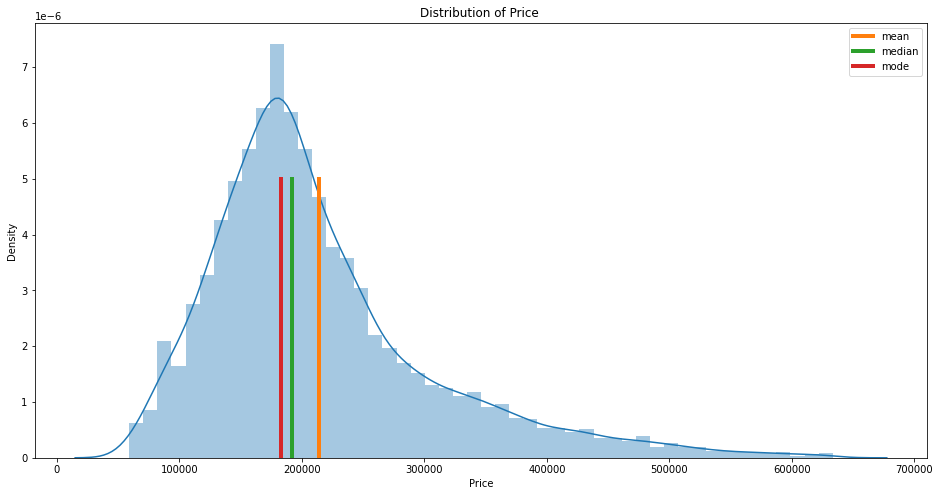

In [19]:
learn_real_features(train,target)

In [8]:
X = train.drop(columns=[target],axis=1)
y = train[target]

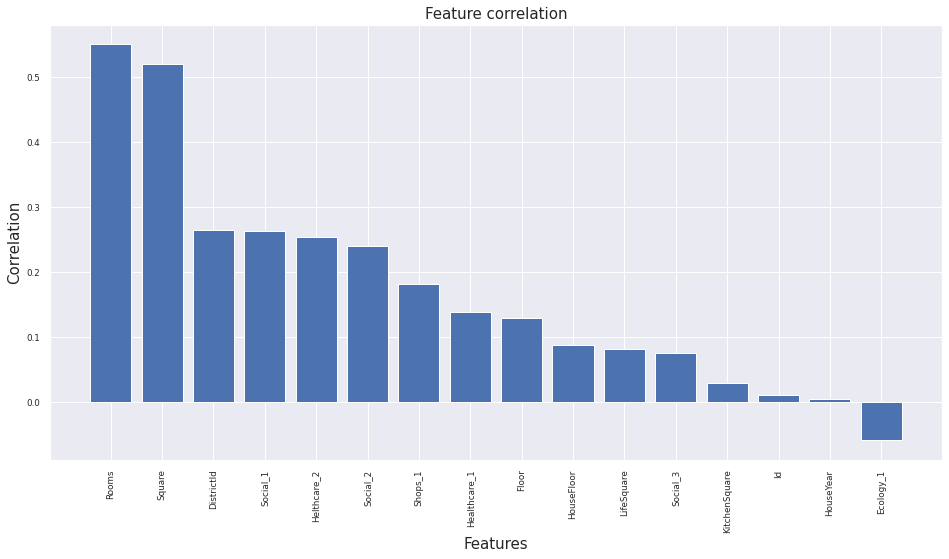

In [23]:
learn_target_correlation(train,target)

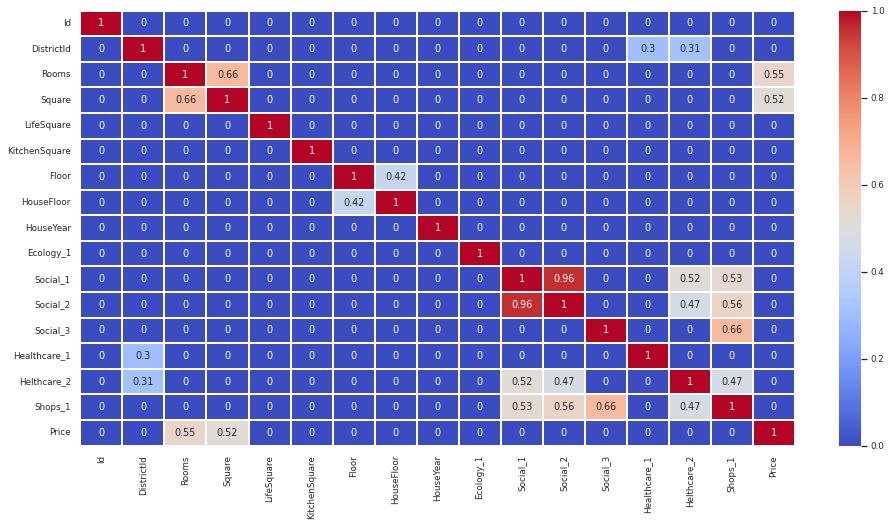

In [42]:

cor_matrix(train,target)

In [9]:
X.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B


In [10]:
data_p = DataPipeline()

data_p.fit(X)
X_train = data_p.transform(X)
y_train = y
test_f = data_p.transform(test_f)


In [11]:
standard_scaler = RobustScaler()
X_train = standard_scaler.fit_transform(X_train)
test_f = standard_scaler.transform(test_f)

In [12]:
from sklearn.model_selection import cross_val_score,KFold


In [13]:
from catboost import CatBoostRegressor

In [14]:
cb_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.02,
    rsm=0.8,
    iterations=2500,
    eval_metric='RMSE',
    depth=8,
    l2_leaf_reg=1
)

cb_model.fit(X_train, y_train,verbose=False, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [15]:
y_train_preds = cb_model.predict(X_train)
print(r2_score(y_train, y_train_preds))


0.9374645141704528


In [16]:

cv_score = cross_val_score(
    cb_model,
    X_train,
    y_train,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

In [17]:
print(f'R2: {round(cv_score.mean(), 3)}')


R2: 0.759


In [44]:
cv_score

array([0.76527689, 0.75489439, 0.7455445 , 0.7587349 , 0.76984671])

In [18]:
predict = cb_model.predict(test_f)

submission['Price'] = predict

submission.to_csv('./results/sub_cB_SC_40.csv',index=False)

## 